In [125]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
import math


import scipy 

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

import sys
sys.path.append("..")

from Ours import Ours
from FD import FD
from Functions import Quadratic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
def create_ellipse(D, N, sample_point):
    scale = sample_point.TLondon @ D @ sample_point
    X = np.random.normal(size=(2, N)) 
    X = X / jnp.linalg.norm(X, axis=0) * jnp.sqrt(scale)
    ellipse = jnp.linalg.inv(jnp.sqrt(D)) @ X
    return scale, ellipse

In [366]:
def create_errs(sig, dim, a_range, num_MC, max_h, jrandom_key, H_sig=0, num_H_runs=1, H_pos=False):

    x_0 = jnp.ones(dim)
    res = []
    S_size = []
    FD_size = []

    for a in tqdm(a_range):
        D = np.eye(dim)
        D[0, 0] = a
        D = jnp.array(D)


        F = Quadratic(1/2 * D, jnp.zeros(dim), 0, sig=sig)

        l = get_mc_loss(F, x_0, num_MC, num_H_runs, H_sig, H_pos)

        S_ours = Ours(sig, max_h=max_h)
        S_FD = FD(sig, is_central=False, h=max_h, use_H=True)

        jrandom_key, subkey = jrandom.split(jrandom_key)
        res.append([l(S_ours, subkey), l(S_FD, subkey)])
        S_size.append([jnp.min(jnp.linalg.norm(S_ours.last_S, axis=0)), jnp.max(jnp.linalg.norm(S_ours.last_S, axis=0))])
        FD_size.append([jnp.min(jnp.linalg.norm(S_FD.last_S, axis=0)), jnp.max(jnp.linalg.norm(S_FD.last_S, axis=0))])

    res = jnp.array(res)
    return res, jnp.array(S_size), jnp.array(FD_size)







In [364]:
def loss_getter(S, dim, N, H, sig):

    S_inv = jnp.linalg.inv(S)

    first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
    second_term = jnp.linalg.norm(S_inv, ord="fro")**2
    third_term = S_inv.T @ jnp.ones(dim)
    third_term = jnp.linalg.norm(third_term)**2
    return 1/4 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)



In [365]:

def get_mc_loss(F, x_0, num_runs, num_H_runs=1, H_sig=None, H_pos=False):
    g_F = F.f1(x_0)
    def helper(grad_getter, jrandom_key):
        errs = []
        for _ in range(num_H_runs):
            jrandom_key, subkey = jrandom.split(jrandom_key)
            H_noise = H_sig * jrandom.normal(subkey,shape=(dim, dim))
            H_noise = (H_noise.T + H_noise)/2.
            if H_pos:
                U, Sigma = jnp.linalg.eigh(H_noise)
                H_noise = U.T @ jnp.abs(Sigma) @ U
            H = F.f2(x_0) + H_noise
        
            for _ in range(num_runs):
                jrandom_key, subkey = jrandom.split(jrandom_key)
                sgd = grad_getter.grad(F, x_0, subkey, H=H)[0]
                errs.append(float(jnp.linalg.norm(sgd - g_F)**2))
        
        errs = jnp.array(errs)
        return jnp.mean(errs), jnp.std(errs), jnp.percentile(errs, 25), jnp.percentile(errs, 75)
    return helper

# Create 2D plots

In [384]:
sig = 1e-1

dim = 2

jrandom_key = jrandom.PRNGKey(10)

a_range = jnp.logspace(-4, 4, 25)
num_MC = 1000

H_sig = 0
max_h = float('inf') #1e2
    
res, S_size, FD_size = create_errs(sig, dim, a_range, num_MC, max_h, jrandom_key)


100%|███████████████████████████████████████████| 25/25 [00:55<00:00,  2.21s/it]


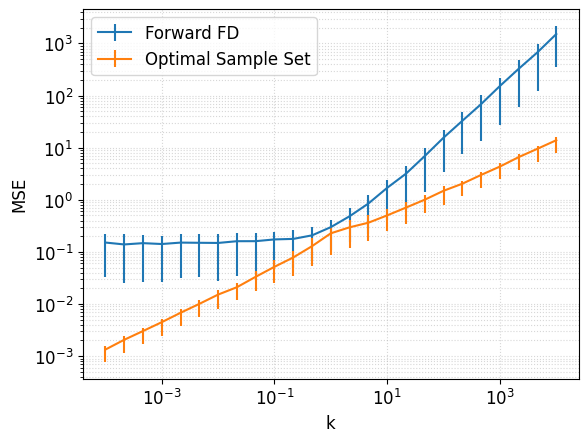

In [385]:
plt.errorbar(a_range, res[:, 1, 0], jnp.abs(res[:, 1, 2:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
plt.errorbar(a_range, res[:, 0, 0], jnp.abs(res[:, 0, 2:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Sample Set")
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)

plt.xlabel("k")
plt.ylabel("MSE")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_{}d_Error.pdf".format(sig, num_MC, dim))
plt.show()


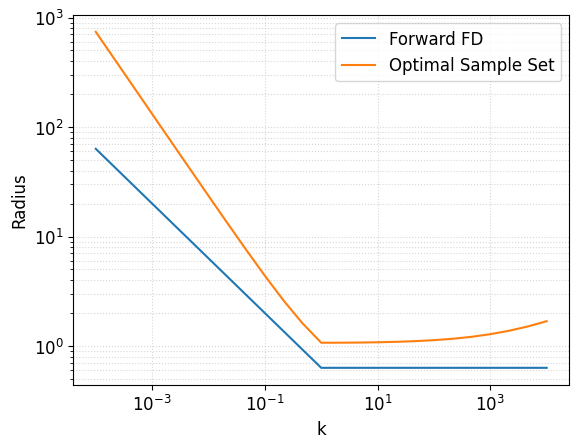

In [378]:
# plt.errorbar(a_range, res[:, 1, 0], (res[:, 1, 3:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
# plt.errorbar(a_range, res[:, 0, 0], (res[:, 0, 3:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.plot(a_range, FD_size[:, 1], label="Forward FD")
plt.plot(a_range, S_size[:, 0], label="Optimal Sample Set")




plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)


plt.xlabel("k")
plt.ylabel("Radius")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_{}d_S_scale.pdf".format(sig, num_MC, dim))

plt.show()





# Visualization

0.02
MC ours (DeviceArray(0.04011189, dtype=float64), DeviceArray(0.02003945, dtype=float64), DeviceArray(0.02609735, dtype=float64), DeviceArray(0.04919624, dtype=float64))
MC FD (DeviceArray(0.2914568, dtype=float64), DeviceArray(0.27620385, dtype=float64), DeviceArray(0.07590532, dtype=float64), DeviceArray(0.44621697, dtype=float64))


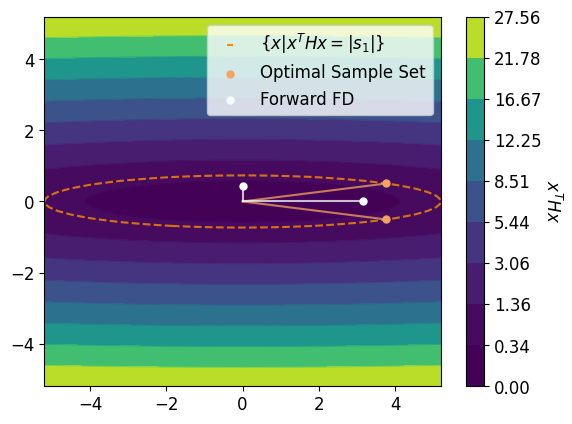

1
MC ours (DeviceArray(0.4997272, dtype=float64), DeviceArray(0.41178298, dtype=float64), DeviceArray(0.17086546, dtype=float64), DeviceArray(0.68536688, dtype=float64))
MC FD (DeviceArray(0.63607512, dtype=float64), DeviceArray(0.57050838, dtype=float64), DeviceArray(0.22632881, dtype=float64), DeviceArray(0.89681751, dtype=float64))


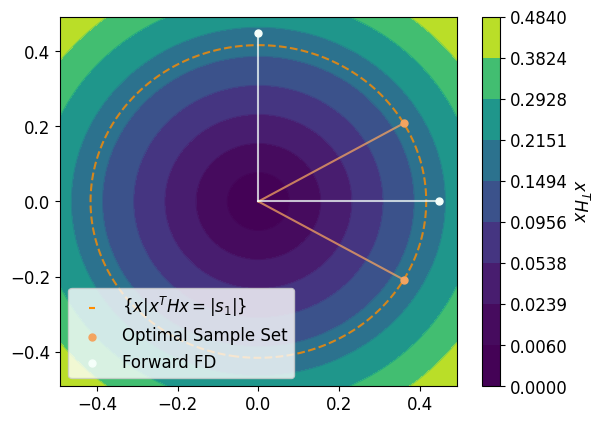

In [89]:
sig = 0.1
jrandom_key = jrandom.PRNGKey(0)

# l = loss_getter(2, 2, D, sig, coeff)
x_0 = jnp.zeros(2)
for a in [0.02, 1]: #jnp.logspace(-3, 1, 10):
    
    print(a)
    
    D = jnp.array([[a, 0], [0, 1]])
    
    jrandom_key, subkey = jrandom.split(jrandom_key)
    
    F = Quadratic(D, b=jnp.zeros(2), c=0, sig=sig)
    
    l = get_mc_loss(F, x_0, 50)
    
    
    S_ours_getter = Ours(sig, max_h=float('inf'))
    S_FD_getter = FD(sig, is_central=False, h=None, use_H=True)
    
    gd_ours, _, _, _, S_ours = S_ours_getter.grad(F, x_0, subkey, H=F.f2(x_0))
    gd_FD, _, _, _, S_FD = S_FD_getter.grad(F, x_0, subkey, H=F.f2(x_0))

    scale, ellipse = create_ellipse(D, 100, S_ours[:, 0])
        
    print("MC ours", l(S_ours_getter, subkey))
    print("MC FD", l(S_FD_getter, subkey))
    
#     plt.scatter(ellipse[0], ellipse[1])



    lim = max([jnp.max(jnp.abs(ellipse)), jnp.max(jnp.abs(S_FD))*1.1])

    
    X = jnp.linspace(-lim, lim, 100)
    X, Y = jnp.meshgrid(X, X)
    XY = np.vstack([X.ravel(), Y.ravel()])
    Z = jnp.diag(XY.T @ D @ XY).reshape(X.shape[0], Y.shape[0])


    levels = [lev**2 for lev in jnp.linspace(0, jnp.sqrt(lim**2 + a * lim**2), 10)]
    
#     plt.contour(X, Y, Z, levels)

    plt.scatter(S_ours[0], S_ours[1], marker="_", color="darkorange", zorder=3, s=25, label=r'$\{x \vert x^T H x = \vert s_1 \vert\}$')#"{x | x^T H x = |s_1|}")
    cp = plt.contourf(X, Y, Z, levels, antialiased=False)
    cp2 = plt.contour(X, Y, Z, levels, linewidths=0.75)

    clb = plt.colorbar(cp)
    clb.ax.set_ylabel('$x^T H x$', rotation="270", labelpad=15)
    
#     clb.ax.set_yticklabels(['{:.0f}'.format(x) for x in clb.ax.yaxis.get_ticklabels()])



    
    plt.scatter(S_ours[0], S_ours[1], color="sandybrown", zorder=3, s=25, label="Optimal Sample Set")
    plt.scatter(S_FD[0], S_FD[1], color="mintcream", zorder=3, s=25, label="Forward FD")
    
    plt.plot([0, S_ours[0, 0]], [0, S_ours[1, 0]], color="sandybrown", alpha=0.75, zorder=2)
    plt.plot([0, S_ours[0, 1]], [0, S_ours[1, 1]], color="sandybrown", alpha=0.75, zorder=2)

    
    plt.plot([0, S_FD[0, 0]], [0, S_FD[1, 0]], color="mintcream", alpha=0.75, zorder=2)
    plt.plot([0, S_FD[0, 1]], [0, S_FD[1, 1]], color="mintcream", alpha=0.75, zorder=2)
    
    plt.contour(X, Y, Z, levels=[scale], linestyles="dashed", alpha=0.8, colors=["darkorange"], zorder=1)




    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    
    plt.legend()


    plt.savefig("Figures/a_{}_sig_{}_2d.pdf".format(a, sig))
    plt.show()
    


In [ ]:
NW10NE

In [83]:
help(plt.contour)

Help on function contour in module matplotlib.pyplot:

contour(*args, data=None, **kwargs)
    Plot contour lines.
    
    Call signature::
    
        contour([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == N`` is the number of columns in *Z* and
        ``len(Y) == M`` is the number of rows in *Z*.
    
        *X* and *Y* must both be ordered monotonically.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(N)``, ``Y = range(M)``.
    
    Z : (M, N) array-like
        The height values over which t

In [38]:
import matplotlib

# Create N-d plots

In [357]:
sig = 1e-1

dim = 32

jrandom_key = jrandom.PRNGKey(10)

a_range = jnp.logspace(-4, 4, 25)

num_MC = 1000

H_sig = 0
max_h = float('inf') #1e2
    
res, S_size, FD_size = create_errs(sig, dim, a_range, num_MC, max_h, jrandom_key)




 16%|███████                                     | 4/25 [01:04<05:39, 16.19s/it]

KeyboardInterrupt



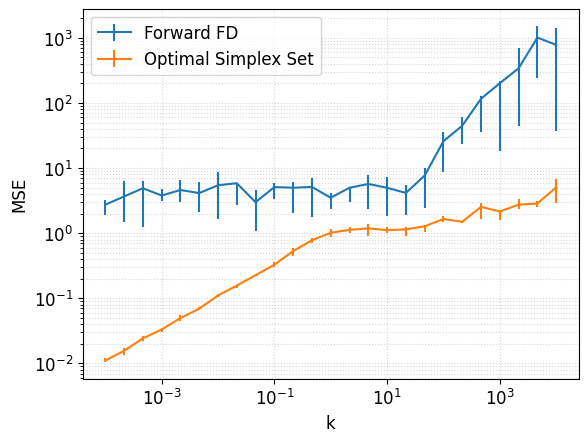

In [343]:
plt.errorbar(a_range, res[:, 1, 0], jnp.abs(res[:, 1, 2:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
plt.errorbar(a_range, res[:, 0, 0], jnp.abs(res[:, 0, 2:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)


plt.xlabel("k")
plt.ylabel("MSE")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_{}d_Error.pdf".format(sig, num_MC, dim))

plt.show()



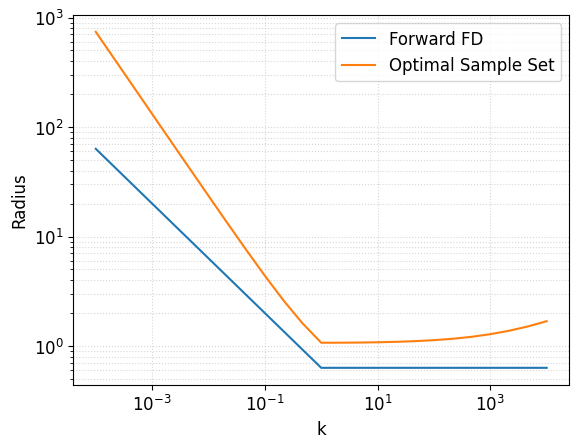

In [185]:
# plt.errorbar(a_range, res[:, 1, 0], (res[:, 1, 3:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
# plt.errorbar(a_range, res[:, 0, 0], (res[:, 0, 3:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.plot(a_range, FD_size[:, 1], label="Forward FD")
plt.plot(a_range, S_size[:, 0], label="Optimal Sample Set")




plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)


plt.xlabel("k")
plt.ylabel("Radius")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_{}d_S_scale.pdf".format(sig, num_MC, dim))

plt.show()






# Err with Noisy H

In [369]:
sig = 1e-1

dim = 2

jrandom_key = jrandom.PRNGKey(11)

a_range = jnp.logspace(-4, 4, 25)

num_MC = 100

H_sig = 1e-1
num_H_runs = 10
max_h = 4
    
res, S_size, FD_size = create_errs(sig, dim, a_range, num_MC, max_h, jrandom_key, H_sig, num_H_runs, H_pos=False)





  0%|                                                    | 0/25 [00:14<?, ?it/s]

KeyboardInterrupt



In [359]:
from jax.lax import dynamic_slice


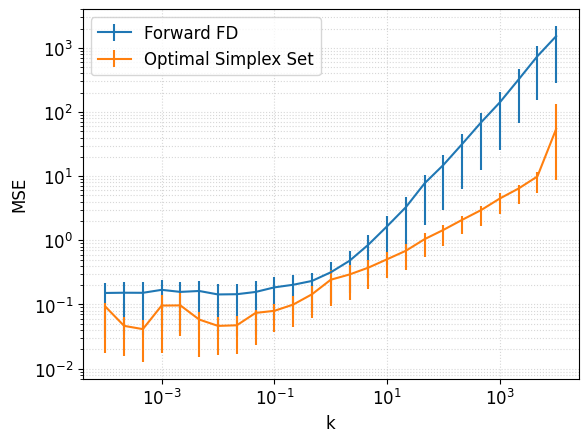

In [368]:
plt.errorbar(a_range, res[:, 1, 0], jnp.abs(res[:, 1, 2:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
plt.errorbar(a_range, res[:, 0, 0], jnp.abs(res[:, 0, 2:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)


plt.xlabel("k")
plt.ylabel("MSE")

plt.legend()

plt.savefig("Figures/sig_{}_Hsig_{}_h_{}_num_{}_numH_{}_{}d_Error.pdf".format(sig, H_sig, max_h, num_MC, num_H_runs, dim))

plt.show()




## I think it is best to stop and not do the noisy H setting. It is too much work for no benefit really. We investigate the noise with the sensitivity analysis. There we look at how well we could do with an optimal H and then with the noisy one. this combines both of these approaches then. 

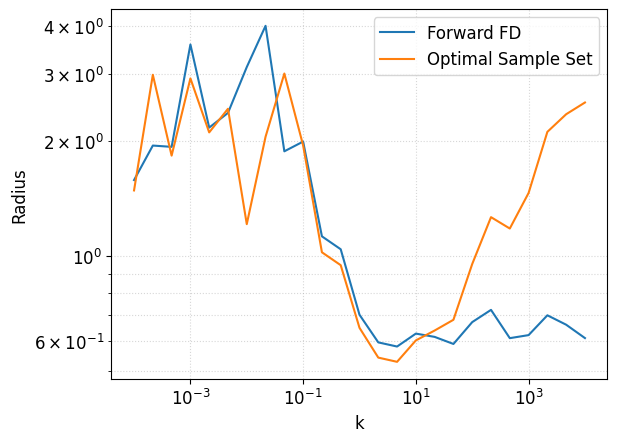

In [370]:
# plt.errorbar(a_range, res[:, 1, 0], (res[:, 1, 3:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
# plt.errorbar(a_range, res[:, 0, 0], (res[:, 0, 3:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.plot(a_range, FD_size[:, 1], label="Forward FD")
plt.plot(a_range, S_size[:, 1], label="Optimal Sample Set")




plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)


plt.xlabel("k")
plt.ylabel("Radius")

plt.legend()

plt.savefig("Figures/sig_{}_Hsig_{}_h_{}_num_{}_{}d_S_scale.pdf".format(sig, H_sig, max_h, num_MC, dim))

plt.show()







In [194]:
S_size

DeviceArray([[15.28476597, 15.28476597],
             [12.63555772, 12.63555772],
             [10.4529148 , 10.4529148 ],
             [47.48669156, 47.48669156],
             [26.83146211, 26.83146211],
             [15.23960199, 15.23960199],
             [ 8.74451476,  8.74451476],
             [ 5.11075167,  5.11075167],
             [ 3.07440692,  3.07440692],
             [ 1.92035162,  1.92035162],
             [ 1.24909364,  1.24909364],
             [ 0.84361235,  0.84361235],
             [ 0.58856619,  0.58856619],
             [ 0.5747464 ,  0.5747464 ],
             [ 0.57977791,  0.57977791],
             [ 0.6072685 ,  0.6072685 ],
             [ 0.66236089,  0.66236089],
             [ 0.75015576,  0.75015576],
             [ 0.87445148,  0.87445148],
             [ 1.038262  ,  1.038262  ],
             [ 1.24540615,  1.24540615],
             [ 1.50166104,  1.50166104],
             [ 1.81521893,  1.81521893],
             [ 2.19687859,  2.19687859],
             [ 2

In [246]:
opt_S = create_approx_S(jnp.diag(jnp.array([1e4, 1, 1, 1, 1, 1, 1])), sig, max_h)

0.008801698684692383
0.004268169403076172
0.0030913352966308594
0.002886056900024414
0.020528078079223633


In [230]:
jnp.linalg.svd(opt_S)

(DeviceArray([[ 1.11022302e-16, -1.00000000e+00],
              [-1.00000000e+00,  1.11022302e-16]], dtype=float64),
 DeviceArray([3.76201227, 0.03760885], dtype=float64),
 DeviceArray([[-0.70710678, -0.70710678],
              [-0.70710678,  0.70710678]], dtype=float64))

In [222]:
max_h

4